# Abstract

4Chan is famous for it's anonymous and ephemeral boards. But is it really ephemeral? There are multiple internet archiving services that have been keeping copies of 4chan posts that go many years in the past. We looked into it to asnwer the following questions: Q1.) *Are 4chan archiving services reliable and offer a holistic view of the epehemeral 4chan threads?* q2.) *If (Q1) is true, does this provides any insights into the pseudo anonymity of the site?* 


In [15]:
%%capture
# needed to support mongo+srv connection strings
!pip install dnspython
!pip install pymongo
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install scipy
!pip install gensim
!pip install langdetect
!pip install tqdm
!pip install nltk
!pip install seaborn
!pip install pyLDAvis
!pip install wordcloud

## Only run once per kernel environment
## Doesn't need to be re-run when kernel is restarted
#import nltk
#nltk.download('punkt')
#nltk.download('averaged_perceptron_tagger')
#nltk.download('wordnet')
#nltk.download('stopwords')


In [17]:
%%capture


from pymongo import MongoClient
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


# Fixed period analysis - change these to extend/restrict the period
# Date as a yyyymmddhhMMss string
date_from = '202105010000'
date_to =   '202111010000'

# connectiong to mongodb cluster using a read only user

## REMOTE REPLICA SET
client = MongoClient("mongodb+srv://<usr>:<pass>@rs.prifti.us/?ssl=false&authSource=chan")

## LOCAL SINGLE INSTANCE
## 192.168.1.110 -- localhost
## client = MongoClient("mongodb://<usr>:<pass>@localhost:27777/?ssl=false&serverSelectionTimeoutMS=5000&connectTimeoutMS=10000&authSource=chan&authMechanism=SCRAM-SHA-256")

# connection to chan database
db = client.chan

# the threads collection contains API data collections from the 4chan api and 4pleb api
threads = db['y-threads']

# the 'live-4chan' collection contains the OXPath data collection
livechan = db['y-live-4chan']


In [20]:
# %%capture

# MongoDB aggregation query, joining data from thread and 'live-4chan' collection 
# for each discovered 4chan thread - retreive a boolean representing if the API data was found
# Fixed period analysis - change these to extend/restrict the period
# Date as a yyyymmddhhMMss string
date_from = '202105010000'
date_to =   '202111010000'


q1_pipeline = [
    # normalise nulls in $data 
    { "$addFields": { "data": { "$cond": [
        {"$and":[ {"$gt": ["$data", None] }, {"data": {"$type": "array"} } ] }, "$data", [{ }]  
      ] } } }
    # only load required fields from 'live-4chan' collection
    ,{ "$project": { "_id": 0, "url": 1, "deleted": "$attributes.deleted", "archived": "$attributes.archived" 
                    ,"first_scan": {"$arrayElemAt": ["$scans", 0 ] }
                    ,"last_scan": {"$arrayElemAt": ["$scans", -1 ] }
                    ,"oxp_op": { "$arrayElemAt": [ "$data", -1 ] } 
                  }
    }
    
    # limit the data to fixed period
   ,{ "$match": {"$and":[ {"first_scan": { "$gt": date_from} }, {"last_scan": { "$lt": date_to }} ] } }  
    # join with 'threads' collection on thread unique URL
   ,{ "$lookup": { 
               "from": "y-threads",
               "localField": "url",
               "foreignField": "_id",
               "as": "api_thread"
       }
    }
   # unwind/expand the joined array 
  ,{ "$unwind": "$api_thread" }
   # remove items where the API scrap job has not been performed
   # this should only affects threads that have not been archived/deleted yet 
  ,{ "$match": { "api_thread.api_scrap": True } }
   #,{ "$project": { "url": 1 }}
   # include the op thread scaped via 4Chan API
  ,{ "$addFields": { "chan_op": { "$cond": [
        {"$and":[ {"$gt": ["$api_thread.chan.posts", None] }] }, "$api_thread.chan.posts", [{ }]  
      ] } } }
   # add the boolean fields that check if chan api fields has data
  ,{ "$project": { "_id": 0, "url": 1, "deleted": 1, "archived": 1, "last_scan": 1
                    ,"oxp_op": "$oxp_op.payload"
                    ,"chan_op": {"$arrayElemAt": ["$chan_op", 0]}
                    ,"chan": {"$gt": [ "$api_thread.chan.posts", { } ] }
                    ,"pleb": "$api_thread.pleb" 
        } 
   }
   # keep the OP/thread from OXpath scrap
  ,{"$unwind": {"path": "$oxp_op", "preserveNullAndEmptyArrays": True } }
   # convert a document to array to better check relevant fields have values
  ,{ "$addFields": {
        "pleb_array": {
                "$ifNull": [ {"$objectToArray": "$pleb"}, [ ] ] 
          }
     } 
   }
   # bring array fields one level up
  ,{ "$unwind": { "path": "$pleb_array", "preserveNullAndEmptyArrays": True } }
   # check the pleb api has data
  ,{ "$project": { "_id": 0, "url": 1, "deleted": 1, "archived": 1, "last_scan": 1,
                    "oxp_op":"$oxp_op.thread.op", "oxp": { "$gt": ["$oxp_op", {} ] }
                  ,"chan": 1, "chan_op": 1
                  ,"pleb_op": "$pleb_array.v.op"
                  ,"pleb": { "$gt": [ "$pleb_array.v.op", { } ] } }
   }
  ,{ "$unwind": {"path": "$oxp_op", "preserveNullAndEmptyArrays": True } }
  ,{ "$unwind": {"path": "$oxp_op", "preserveNullAndEmptyArrays": True } }
 #,{ "$group": { _id: null, "count": { $sum: 1 } } }
  ,{ "$sort": {"last_scan": -1} } 
]

# run the aggregation
match_result = pd.DataFrame(livechan.aggregate(q1_pipeline, allowDiskUse=True))


In [21]:
match_result

,url,deleted,archived,last_scan,chan_op,chan,oxp,pleb_op,pleb,oxp_op
0,https://boards.4chan.org/pol/thread/345511307,False,True,20211031235904,{},False,False,"{'doc_id': '321648245', 'num': '345511307', 's...",True,NaN
1,https://boards.4chan.org/pol/thread/345544668,False,True,20211031235904,{},False,False,"{'doc_id': '321681512', 'num': '345544668', 's...",True,NaN
2,https://boards.4chan.org/pol/thread/345545223,False,True,20211031235904,{},False,False,"{'doc_id': '321682079', 'num': '345545223', 's...",True,NaN
3,https://boards.4chan.org/pol/thread/345545415,False,True,20211031235904,{},False,False,"{'doc_id': '321682252', 'num': '345545415', 's...",True,NaN
4,https://boards.4chan.org/pol/thread/345537604,False,True,20211031235805,{},False,False,"{'doc_id': '321674445', 'num': '345537604', 's...",True,NaN
...,...,...,...,...,...,...,...,...,...,...
407931,https://boards.4chan.org/pol/thread/319461189,False,False,20210501002857,{},False,True,"{'doc_id': '295621738', 'num': '319461189', 's...",True,{'image': ['//i.4cdn.org/pol/1619828463836.jpg...
407932,https://boards.4chan.org/pol/thread/319459954,False,False,20210501002656,"{'no': 319459954, 'closed': 1, 'now': '04/30/2...",True,True,"{'doc_id': '295620477', 'num': '319459954', 's...",True,{'image': ['//i.4cdn.org/pol/1619827838385.jpg...
407933,https://boards.4chan.org/pol/thread/319458666,False,False,20210501002156,"{'no': 319458666, 'closed': 1, 'now': '04/30/2...",True,True,"{'doc_id': '295619151', 'num': '319458666', 's...",True,{'image': ['//i.4cdn.org/pol/1619827175027.png...
407934,https://boards.4chan.org/pol/thread/319458870,False,False,20210501001911,"{'no': 319458870, 'closed': 1, 'now': '04/30/2...",True,True,"{'doc_id': '295619448', 'num': '319458870', 's...",True,{'image': ['//i.4cdn.org/pol/1619827276328.jpg...


There are **407936** threads crawled during the period in question. 
Of these there are **406820** threads that have been found in 4pleb archiving API. This is equivalent to **99.726%** match.
Nr of matching threads we have collected data from all three sources (OXPATH, 4CHAN, 4PLEB): 103322, that is **25.328%** 
Plot showing the distribution of missed threads through out the 24 hour (UK Time)


(array([236., 308.,   6.,   1.,   1.,   1.,  44.,  40.,  50.,  60.,  60.,
        101.,  20.,   2.,   0., 171.,  81.,   9., 100., 140., 240.,  40.,
         41., 120.]),
 array([0.0, 0.9583333333333334, 1.9166666666666667, 2.875,
        3.8333333333333335, 4.791666666666667, 5.75, 6.708333333333334,
        7.666666666666667, 8.625, 9.583333333333334, 10.541666666666668,
        11.5, 12.458333333333334, 13.416666666666668, 14.375,
        15.333333333333334, 16.291666666666668, 17.25, 18.208333333333336,
        19.166666666666668, 20.125, 21.083333333333336, 22.041666666666668,
        23.0], dtype=object),
 <BarContainer object of 24 artists>)

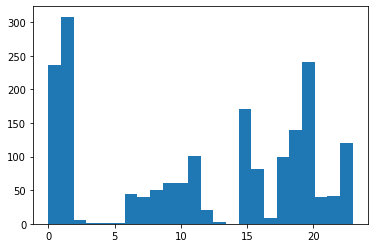

In [22]:
# %%capture

## Length of the dataset where there is data from 4Chan API (chan), 4Pleb API (pleb) and OXPath Scrap (oxp)
full_match_len = len(match_result.query("chan & pleb & oxp" ))


print(f'There are **{len(match_result)}** threads crawled during the period in question. ')
print(f'Of these there are **{match_result.pleb.sum()}** threads that have been found in 4pleb archiving API. This is equivalent to **{"%.3f" % (match_result.pleb.sum()/len(match_result)*100)}%** match.')
print(f'Nr of matching threads we have collected data from all three sources (OXPATH, 4CHAN, 4PLEB): {full_match_len}, that is **{"%.3f" % (full_match_len/len(match_result)*100)}%** ')

# Select only items that have not been found on 4pleb
f1 = match_result[match_result.pleb==False]
# Of these, select only items that have not been scaped from 4chan
f2 = f1 # ^ paused - f2 used as f1 later - do not change
# Of these, select the items where we have a copy of the data from oxpath but not found on 4chan and 4pleb
f3 = f2[f2.oxp == True]



# Show the data  from original post scraped using OXPath
oxp_op = pd.DataFrame(list(f3['oxp_op']))
post_date = oxp_op.explode('date_time')

post_date['date_time'] = pd.to_datetime(post_date['date_time'], format='%m/%d/%y(%a)%X')
post_date=post_date.sort_values(by='date_time')

dates = post_date.date_time

times = pd.DatetimeIndex(dates)
grp = dates.groupby([times.hour])

print('Plot showing the distribution of missed threads through out the 24 hour (UK Time)')

cnt = grp.agg(['count'])

my_df = pd.DataFrame([cnt.index, cnt.values])
my_df = my_df.transpose()
my_df.columns = ['time_of_day','nr_missed_threads']
my_df = my_df.explode('nr_missed_threads')
#my_df
#grouped.agg(['count'])
plt.hist(my_df.time_of_day, bins=24, weights=my_df.nr_missed_threads)
#np.mean(my_df.nr_missed_threads)



In [23]:
# %%capture

import scipy.stats as st
import statistics as stat

def rolling(time_series):
  diff, _d_from, _d_to = [],[],[]
  for i in range(1, len(time_series)-1):
      temp_diff = (time_series[i] - time_series[i-1]).total_seconds() / 60
      diff.append(temp_diff)
      _d_from.append(time_series[i-1])
      _d_to.append(time_series[i])
  return pd.DataFrame({"Gap": diff, "From": _d_from, "To": _d_to})


sorted_freq = freq_dataset#.sort_values(by=["scan_num"])
count = sorted_freq['count']
scan = list(sorted_freq['scan'])
_to_date = scan[0]
_from_date = scan[len(scan) - 1]
_minutes = (_from_date - _to_date).total_seconds() / 60
_total_scans = count.sum()

print(f'Total scans {len(freq_dataset)}')
print(f'First Scan: {_from_date}, Last Scan: {_to_date}, Total Minutes {_minutes}')
print(f"Total Scans {_total_scans}, Avg scans per minute {'%.2f' % (_total_scans/_minutes )}")
print(f'Scan frequency mean {"%.2f" % stat.mean(count)}, geometric mean {"%.2f" % st.gmean(count)}, \
median {stat.median(count)}, std {"%.2f" % stat.stdev(count)}')
rolling(scan).sort_values(by=["Gap"], ascending=False).head(10)

perc_match = (match_result.pleb.sum()/len(match_result))*100
perc_not_match = (1-(match_result.pleb.sum()/len(match_result)))*100
not_pleb_match = match_result.query("pleb==False")
not_pleb_yes_chan = not_pleb_match.query("chan")

result_rolling = rolling(scan).sort_values(by=["Gap"], ascending=False)#.head(10)
result_rolling

Total scans 2516
First Scan: 2022-04-17 17:57:00, Last Scan: 2022-04-16 00:01:00, Total Minutes 2516.0
Total Scans 10942, Avg scans per minute 4.35
Scan frequency mean 4.35, geometric mean 4.20, median 4.0, std 1.04


,Gap,From,To
698,2.0,2022-04-16 11:39:00,2022-04-16 11:41:00
1669,1.0,2022-04-17 03:51:00,2022-04-17 03:52:00
1671,1.0,2022-04-17 03:53:00,2022-04-17 03:54:00
1672,1.0,2022-04-17 03:54:00,2022-04-17 03:55:00
1673,1.0,2022-04-17 03:55:00,2022-04-17 03:56:00
...,...,...,...
839,1.0,2022-04-16 14:01:00,2022-04-16 14:02:00
840,1.0,2022-04-16 14:02:00,2022-04-16 14:03:00
841,1.0,2022-04-16 14:03:00,2022-04-16 14:04:00
842,1.0,2022-04-16 14:04:00,2022-04-16 14:05:00


In [24]:
# %%capture

not_pleb_not_chan_oxp = not_pleb_match.query("chan==False & oxp==True")
not_pleb_yes_chan_or_oxp = not_pleb_match.query("chan | (chan==False & oxp==True)")
print(f'Nr items that are not in 4pleb but are in 4chan {(len(not_pleb_yes_chan)/len(not_pleb_match))*100}')

def get_num(url: str) -> int:
    return int(url.split('/')[-1])

def get_num_str(url: str) -> str:
    return url.split('/')[-1]
 
pleb_qry = match_result.query("pleb & deleted==True")
chan_pleb_qry = pleb_qry.query("chan")
# Show the data  from original post
pleb_posts = pd.DataFrame(list(pleb_qry['pleb_op']))
chan_posts = pd.DataFrame(list(chan_pleb_qry['chan_op']))
print('Pleb Deleted {}'.format(len(pleb_posts.query("deleted=='1'"))))
print(f'Oxp Deleted {len(pleb_posts)}')
id_chan_posts = list(chan_posts.query('filedeleted != "NaN"')['no'])
match_result['num'] = match_result['url'].apply(get_num)
#match_result
num_del_chan = len(match_result[match_result['num'].isin(id_chan_posts)].query('deleted==True'))


id_pleb_posts = pleb_posts.query("deleted=='1'")['num']
match_result['num'] = match_result['url'].apply(get_num_str)
print(len(id_pleb_posts))
print(len(match_result[match_result['num'].isin(id_pleb_posts)].query('deleted==True')))




Nr items that are not in 4pleb but are in 4chan 34.946236559139784
Pleb Deleted 6600
Oxp Deleted 11054
6600
6600


# Introduction

We have been collecting posts from the the /pol board of 4chan with high frequency (scaning the board multiple times per minute). 

We have done so by simulating an end user that connects to the side with a conventional borwser (Firefox), using [OXPath](https://github.com/oxpath/oxpath)

We have been taking multiple snapshots of each thread until the thread was archived. When a thread is archived we then have been taking a snapshot of the thread from the 4chan api and one from 4pleb.org, an 4chan archiving service, believed to be the most complete archiving service on 4chan. 

Two type of agents have been used to collect the data using OXpath. 

- A discovery crawling agent that continuously crawls the /pol board looking for new threads and either a.) captures and queues the new thread URLs for scraping or b.) updates the *found* timestamp of a thread that had already been found by previous instances of the crawler. 

- A extraction scraping agent that continuously scrapes threads queued by the crawling agent and stores the state of the thread together with the timestamp, unless the agent finds the thread to be *archived* or *deleted*. When the thread is found in the *archived* / *deleted* state, its attributes are updated and the thread is removed from the crawling queue. 


# Data overview


Whilst there is a continous stream of data, to ensure reproducibility, this analisys is specifically to the dates between {{date_from}} and {{date_to}}.

The data collected by scanning the 4chan /pol board has the following caracteristics: 

|Property   | Value   | Description   |
|---|---|---|
|Total Threads   |{{len(match_result)}}   | The number of total threads found   |
|Total 4Pleb Threads   |{{match_result.pleb.sum()}}  / {{"%.3f" % (match_result.pleb.sum()/len(match_result)*100)}}% | Number/Percentage of threads also found on 4Pleb API  |
|Three way Matched Threads   | {{full_match_len}} / {{"%.3f" % (full_match_len/len(match_result)*100) }}% | The number of threads where we have collected data from all three sources  |
|First-Last scan | {{ _from_date.strftime("%d/%m/%Y, %H:%M:%S") }} **-** {{ _to_date.strftime("%d/%m/%Y, %H:%M:%S") }}  | The first and the last scan in the dataset   |
|Total Minutes   | {{ _minutes }}   | The total minutes elapsed between the two dates   |
|Total Scans   | {{_total_scans}}   | The total number of scans seen on the dataset. That is the number of times we crawled the /pol board to find new threads   |
|Scans per minute| {{'%.2f' % (_total_scans/_minutes )}}  | The avg scans per minute based on the total minutes elapsed between the two dates |
|Frequency mean| {{"%.2f" % stat.mean(count)}}  | The avg scans per minute based on the minutes where there has been scans (there are gaps in the dataset) |
|Median | {{stat.median(count)}}   | The median value of scans per minute |
|Standard Deviation| {{"%.2f" % stat.stdev(count)}} | The std of observed scans per minute |



In [25]:
# %%capture

deleted_threads = match_result.query('pleb').query("deleted==True")
deleted_threads = pd.DataFrame(list(deleted_threads['pleb_op']))
deleted_threads = deleted_threads.drop(columns=['doc_id', 'subnum', 'thread_num', 'op', 'capcode', 'email', 'name', 'exif'])
deleted_threads = deleted_threads.drop(columns=['trip','sticky', 'locked', 'poster_hash_processed', 'poster_country_name_processed', 'troll_country_code', 'troll_country_name', 'since4pass', 'unique_ips', 'extra_data', 'media', 'board'])
deleted_threads = deleted_threads.drop(columns=['trip_processed', 'email_processed', 'name_processed', 'formatted'])
#document_corp = ', '.join(list(deleted_threads.query('title != None')['title']))

#len(deleted_threads)
#len(deleted_threads.query('deleted=="1"'))
deleted_threads = deleted_threads.query('deleted=="0"')

In [26]:
# %%capture

deleted_threads['articles'] = deleted_threads['title'] + ' ' + deleted_threads['comment']
document_corp = list(deleted_threads['articles'])
document_corp = [x for x in document_corp if x is not None]
document_corp = pd.DataFrame(document_corp)
#document_corp.shape
document_corp.columns = ['articles']
document_corp = document_corp.dropna().reset_index(drop=True)
#temp_title = list(deleted_threads.query('title != None')['title'])
#temp_title = [x for x in temp_title if x is not None]


#temp_comments = list(deleted_threads.query('comment != None')['comment'])
#temp_comments = [x for x in temp_comments if x is not None]
#document_corp = temp_title + temp_comments
#len(document_corp)


In [27]:
# %%capture

from langdetect import detect
from tqdm import notebook
notebook.tqdm().pandas()
data = document_corp.copy()

def try_detect(elem):
    try: 
        return detect(elem)
    except:
        return 'n/a'

data['lang'] = data.articles.progress_map(try_detect)
data['lang'].head(5)


0    en
1    en
2    en
3    en
4    en
Name: lang, dtype: object

In [28]:
# %%capture

from nltk.tokenize import sent_tokenize


data.lang.value_counts()
data_en = data.loc[data.lang=='en']
data['sentences'] = data.articles.progress_map(sent_tokenize)
data['sentences'].head(1).tolist()[0][:3] # Print the first 3 sentences of the 1st article

['Australia health orders This thread is political as it is about current politically motivated restrictions in Australia.',
 "Aus bros I need some help here, I hear a lot about legal restrictions and confronting police about their legality (I'm in Vic but whatever state).",
 'Can you fellas help me and any other aussies with some solid things to say to cops and any advice in general?']

In [29]:
# %%capture

from nltk.tokenize import word_tokenize
data['tokens_sentences'] = data['sentences'].progress_map(lambda sentences: [word_tokenize(sentence) for sentence in sentences])
print(data['tokens_sentences'].head(1).tolist()[0][:3])



[['Australia', 'health', 'orders', 'This', 'thread', 'is', 'political', 'as', 'it', 'is', 'about', 'current', 'politically', 'motivated', 'restrictions', 'in', 'Australia', '.'], ['Aus', 'bros', 'I', 'need', 'some', 'help', 'here', ',', 'I', 'hear', 'a', 'lot', 'about', 'legal', 'restrictions', 'and', 'confronting', 'police', 'about', 'their', 'legality', '(', 'I', "'m", 'in', 'Vic', 'but', 'whatever', 'state', ')', '.'], ['Can', 'you', 'fellas', 'help', 'me', 'and', 'any', 'other', 'aussies', 'with', 'some', 'solid', 'things', 'to', 'say', 'to', 'cops', 'and', 'any', 'advice', 'in', 'general', '?']]


In [30]:
# %%capture

from nltk import pos_tag
data['POS_tokens'] = data['tokens_sentences'].progress_map(lambda tokens_sentences: [pos_tag(tokens) for tokens in tokens_sentences])
print(data['POS_tokens'].head(1).tolist()[0][:3])


[[('Australia', 'NNP'), ('health', 'NN'), ('orders', 'NNS'), ('This', 'DT'), ('thread', 'NN'), ('is', 'VBZ'), ('political', 'JJ'), ('as', 'IN'), ('it', 'PRP'), ('is', 'VBZ'), ('about', 'IN'), ('current', 'JJ'), ('politically', 'RB'), ('motivated', 'JJ'), ('restrictions', 'NNS'), ('in', 'IN'), ('Australia', 'NNP'), ('.', '.')], [('Aus', 'NNP'), ('bros', 'NN'), ('I', 'PRP'), ('need', 'VBP'), ('some', 'DT'), ('help', 'NN'), ('here', 'RB'), (',', ','), ('I', 'PRP'), ('hear', 'VBP'), ('a', 'DT'), ('lot', 'NN'), ('about', 'IN'), ('legal', 'JJ'), ('restrictions', 'NNS'), ('and', 'CC'), ('confronting', 'VBG'), ('police', 'NNS'), ('about', 'IN'), ('their', 'PRP$'), ('legality', 'NN'), ('(', '('), ('I', 'PRP'), ("'m", 'VBP'), ('in', 'IN'), ('Vic', 'NNP'), ('but', 'CC'), ('whatever', 'WDT'), ('state', 'NN'), (')', ')'), ('.', '.')], [('Can', 'MD'), ('you', 'PRP'), ('fellas', 'VB'), ('help', 'VB'), ('me', 'PRP'), ('and', 'CC'), ('any', 'DT'), ('other', 'JJ'), ('aussies', 'NNS'), ('with', 'IN'), (

In [31]:
# %%capture

# Inspired from https://stackoverflow.com/a/15590384
from nltk.corpus import wordnet
from nltk.stem.wordnet import WordNetLemmatizer


def get_wordnet_pos(treebank_tag):

    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return ''

lemmatizer = WordNetLemmatizer()

# Lemmatizing each word with its POS tag, in each sentence
data['tokens_sentences_lemmatized'] = data['POS_tokens'].progress_map(
    lambda list_tokens_POS: [
        [
            lemmatizer.lemmatize(el[0], get_wordnet_pos(el[1])) 
            if get_wordnet_pos(el[1]) != '' else el[0] for el in tokens_POS
        ] 
        for tokens_POS in list_tokens_POS
    ]
)

data['tokens_sentences_lemmatized'].head(1).tolist()[0][:3]

[['Australia',
  'health',
  'order',
  'This',
  'thread',
  'be',
  'political',
  'as',
  'it',
  'be',
  'about',
  'current',
  'politically',
  'motivated',
  'restriction',
  'in',
  'Australia',
  '.'],
 ['Aus',
  'bros',
  'I',
  'need',
  'some',
  'help',
  'here',
  ',',
  'I',
  'hear',
  'a',
  'lot',
  'about',
  'legal',
  'restriction',
  'and',
  'confront',
  'police',
  'about',
  'their',
  'legality',
  '(',
  'I',
  "'m",
  'in',
  'Vic',
  'but',
  'whatever',
  'state',
  ')',
  '.'],
 ['Can',
  'you',
  'fellas',
  'help',
  'me',
  'and',
  'any',
  'other',
  'aussie',
  'with',
  'some',
  'solid',
  'thing',
  'to',
  'say',
  'to',
  'cop',
  'and',
  'any',
  'advice',
  'in',
  'general',
  '?']]

In [32]:
# %%capture

from nltk.corpus import stopwords

stopwords_verbs = ['https', 'http', 'say', 'get', 'go', 'know', 'may', 'need', 'like', 'make', 'see', 'want', 'come', 'take', 'use', 'would', 'can']
stopwords_other = ['one', 'mr', 'image', 'getty', 'de', 'en', 'caption', 'also', 'copyright', 'something']
my_stopwords = stopwords.words('english') + stopwords_verbs + stopwords_other


In [33]:
# %%capture

from itertools import chain # to flatten list of sentences of tokens into list of tokens
data['tokens'] = data['tokens_sentences_lemmatized'].map(lambda sentences: list(chain.from_iterable(sentences)))
data['tokens'] = data['tokens'].map(lambda tokens: [token.lower() for token in tokens if token.isalpha() 
                                                    and token.lower() not in my_stopwords and len(token)>1])
data['tokens'].head(1).tolist()[0][:30]


['australia',
 'health',
 'order',
 'thread',
 'political',
 'current',
 'politically',
 'motivated',
 'restriction',
 'australia',
 'aus',
 'bros',
 'help',
 'hear',
 'lot',
 'legal',
 'restriction',
 'confront',
 'police',
 'legality',
 'vic',
 'whatever',
 'state',
 'fellas',
 'help',
 'aussie',
 'solid',
 'thing',
 'cop',
 'advice']

In [34]:
# %%capture

from gensim.models import Phrases
from gensim import corpora

tokens = data['tokens'].tolist()
bigram_model = Phrases(tokens)
trigram_model = Phrases(bigram_model[tokens], min_count=1)
tokens = list(trigram_model[bigram_model[tokens]])

dictionary_LDA = corpora.Dictionary(tokens)
dictionary_LDA.filter_extremes(no_below=3)
corpus = [dictionary_LDA.doc2bow(tok) for tok in tokens]


In [35]:
# %%capture

from gensim import models
import numpy as np

np.random.seed(123456)
num_topics = 20
%time lda_model = models.LdaModel(corpus, num_topics=num_topics, \
                                  id2word=dictionary_LDA, \
                                  passes=4, alpha=[0.01]*num_topics, \
                                  eta=[0.01]*len(dictionary_LDA.keys()))






CPU times: user 9.72 s, sys: 0 ns, total: 9.72 s
Wall time: 9.73 s


In [36]:
# %%capture

import seaborn as sns;

topics = [lda_model[corpus[i]] for i in range(len(data))]

def topics_document_to_dataframe(topics_document, num_topics):
    res = pd.DataFrame(columns=range(num_topics))
    for topic_weight in topics_document:
        res.loc[0, topic_weight[0]] = topic_weight[1]
    return res


# Like TF-IDF, create a matrix of topic weighting, with documents as rows and topics as columns
document_topic = pd.concat([topics_document_to_dataframe(topics_document, num_topics=num_topics) for topics_document in topics]) \
  .reset_index(drop=True).fillna(0)




<AxesSubplot:>

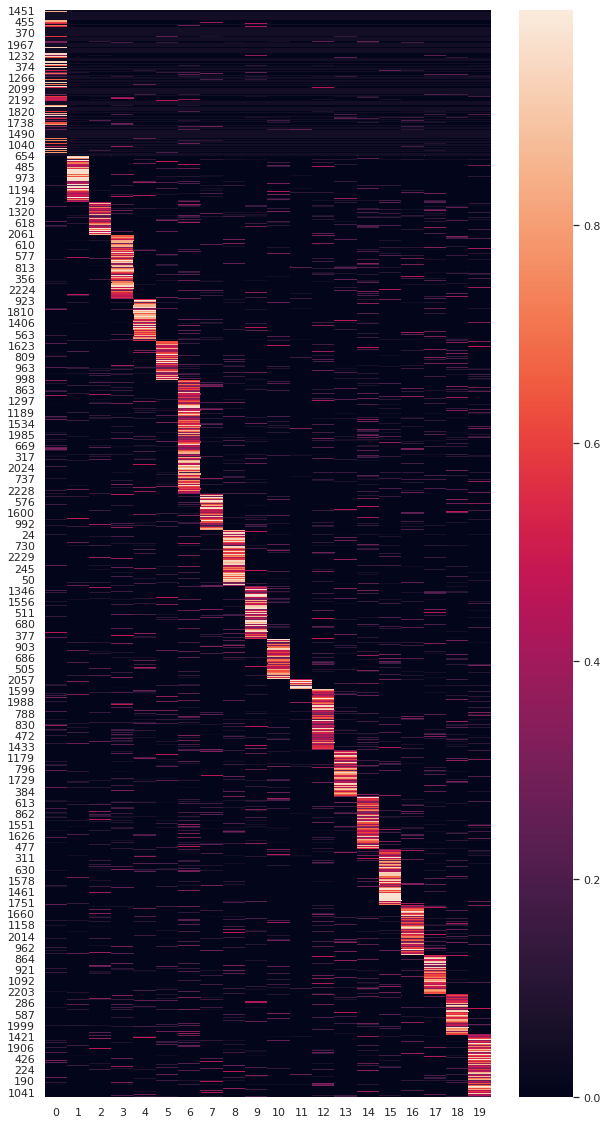

In [37]:
# %%capture

document_topic.head()

%matplotlib inline
sns.set(rc={'figure.figsize':(10,20)})
sns.heatmap(document_topic.loc[document_topic.idxmax(axis=1).sort_values().index])

<AxesSubplot:>

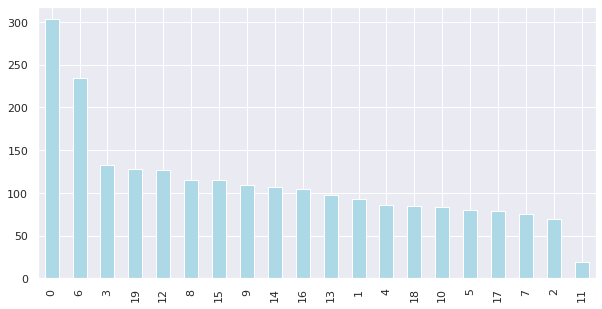

In [38]:
# %%capture

sns.set(rc={'figure.figsize':(10,5)})
document_topic.idxmax(axis=1).value_counts().plot.bar(color='lightblue')

In [39]:
# %%capture

# https://cran.r-project.org/web/packages/LDAvis/vignettes/details.pdf
# Here a short legend to explain the vis:
# size of bubble: proportional to the proportions of the topics across the N total tokens in the corpus
# red bars: estimated number of times a given term was generated by a given topic
# blue bars: overall frequency of each term in the corpus
# -- Relevance of words is computed with a parameter lambda
# -- Lambda optimal value ~0.6 (https://nlp.stanford.edu/events/illvi2014/papers/sievert-illvi2014.pdf)
%matplotlib inline
import pyLDAvis
import pyLDAvis.gensim
vis = pyLDAvis.gensim.prepare(topic_model=lda_model, corpus=corpus, dictionary=dictionary_LDA)
pyLDAvis.enable_notebook()
pyLDAvis.display(vis)


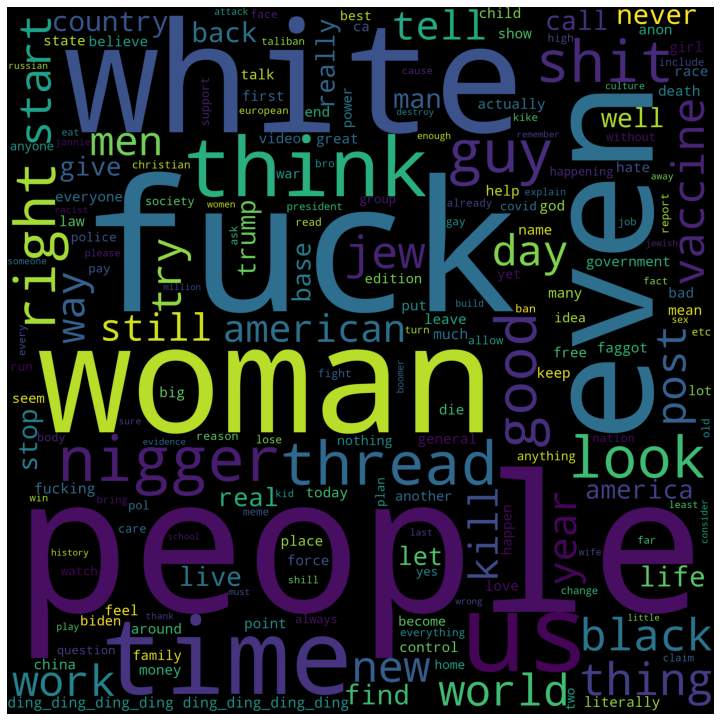

In [40]:
# %%capture
from wordcloud import WordCloud,STOPWORDS

def showWordCloud(data):
    words = ' '.join(data)
    cleaned_word = " ".join([word for word in words.split()])
    wordcloud = WordCloud(stopwords = STOPWORDS,
                         background_color = 'black',
                         width = 2500,
                         height = 2500
                         ).generate(cleaned_word)
    plt.figure(1,figsize = (13,13))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

flat_list = [item for sublist in tokens for item in sublist]

#flat_list
showWordCloud(flat_list)

# Comparison Questions

### Q1.) ***What is the archiving service 4plen coverage of 4chan and what is the quality of the coverage?***


Between the dates of **{{_from_date.strftime("%d/%m/%Y, %H:%M:%S") }}** and **{{_to_date.strftime("%d/%m/%Y, %H:%M:%S") }}** we have crawled **{{ "{:,}".format(len(match_result)) }}** threads on 4chan /pol board. 

Of these, we have collected data from all three sources - 4chan scrap using OXPath, 4chan API and 4pleb API (i.e. scraped thread, posts content and metadata) on **{{full_match_len}} / {{"%.3f" % (full_match_len/len(match_result)*100)}} %** of the results.

We have found on the 4chan archiving service, 4pleb, **{{match_result.pleb.sum()}}  / {{"%.3f" % perc_match }}%** of the results.

Looking into the remainder **{{ len(match_result) - match_result.pleb.sum() }} / {{"%.3f" % perc_not_match }}%** that are not found in the archiving service we have noticed that: 

- We have scraped **{{ len(not_pleb_yes_chan) }} / {{ "%.3f" % (len(not_pleb_yes_chan)/len(not_pleb_match)*100) }}%** threads from 4chan API but not found on 4pleb. 
- We have scraped **{{ len(not_pleb_yes_chan_or_oxp) }} / {{ "%.3f" % (len(not_pleb_yes_chan_or_oxp)/len(not_pleb_match)*100) }}** using OXPath or 4chan API scraping methods. Of these **{{ len(not_pleb_match.query("oxp")) }}** is the number of items scraped using OXPath.

The analysis of the deleted threads could lead to insight on how threads are being monitored 

- There are **{{ "{:,}".format(len(match_result.query("deleted==True"))) }}** threads that have been marked as deleted by the OXPath scraper. Of the deleted threads, **{{ "{:,}".format(len(match_result.query("pleb").query("deleted==True"))) }}** have been found been found on the 4pleb archiving API. 
- There are **{{ len(id_chan_posts) }}** threads found on 4chan API that have been marked as deleted. **{{ num_del_chan }}** have also been found and marked as deleted by OXpath scraper
- There are **{{ len(pleb_posts.query("deleted=='1'")) }}** threads marked as deleted in 4pleb. **{{len(match_result[match_result['num'].isin(id_pleb_posts)].query('deleted==True'))}}** have also been found and marked as deleted by OXpath scraper

The deleted threads seems to behave according to the following pattern:

* Threads are posted by original poster (op)
* There is some activity on the thread (replies and/or reads) 
* The thread becomes in-accessible and its URL return *404 - Page not found*
    * The OXPath scraper marks the thread as deleted
* Some threads are deleted permanently whilst others are returned on the main board and the activity continues
    * We can assume that **{{ "%.3f" % ( (len(pleb_posts.query("deleted=='1'")) / len(match_result.query("pleb").query("deleted==True"))) * 100)  }}%** of the cases that 4pleb also finds to be deleted, is the actual number of deleted threads
    


### Q1.1) - What topics of threads are being deleted and what is the difference between the ones permanently deleted and the ones put back on the board? 

When analysing deleted threads we have to take into consideration the following question: 
    ***How do we know when a thread has been deleted?*** 

The question is non trivial because ultimately ***all*** threads get deleted from 4chan. We are interested in a ***deleted*** status of the thread outside of it's expected life cycle.  The live expectancy of a thread $L_t$ (i.e. the elapsed amount of time during which a thread is reachable by it's uniquer URL) is composed of two components: $E_b$ - *Elapsed* time on the *board* and $E_a$ - *Elapsed* time *archived*. 

\begin{equation} \label{eq1}
    L_t = E_b + E_a 
\end{equation}

The second component $E_a$ is expected to be constant. All threads remain available for three days after they are archived. <span class="mark">(add reference)</span>

The first element, the elapsed time a thread spends on the board $E_b$, is an entity of time, and function of activity and janitor moderation. The activity on a thread is a combination of posts/images/authors. We can simplify this by only considering the number of posts (i.e. replies). Each new post bumps the thread up on the board, delaying it's archiving time <span class="mark">(add reference)</span> . The bumping effect is also a function that decays with time. Alternatively, since $E_b$ already represents time, it can be expressed based on the number of posts $p$. Similarly, the rate of decay $\beta$  grows as the number of posts on the thread grows (each posts bumps the thread up a bit, but every time less than the previous).


Furthermore, emerging from data, at times threads gets removed from the board and appear to be deleted. This is expected as 4chan has various levels of moderation by its *janitors*. Since threads can also be in a deleted state and then put back in the live board we are going to consider $P(d)$ as the probability of a threat being deleted with it's values $P(d) \in [0,1]  where  P(d)=0$ thread was not deleted, $P(d)=1$ thread was deleted, $P(d) \in (0,1)$ thread was deleted for a certain amount of time as percentage of its elapsed time and then put back in the live board.

\begin{equation}
    E_b = [log(np)(1-\frac{p}{max_p})^{log(p)}]*(1-P(d))
\end{equation}

Since we know that n = 200, and assuming $P(d)$ only affects threads in the live board

\begin{equation}
    L_t = [log(200p)(1-\frac{p}{max_p})^{log(p)}]*(1-P(d)) + E_a
\end{equation}

where 

- $L_t$ Elapsed life (time) of a thread
- $n$ Number of threads on the board
- $p$ Number of posts on the thread
- $max_p$ The maximum number of posts any thread on the board has
- $\beta = p/max_p$ rate of decay of the thread through out the board
- $P(d)$ The probability that a thread has been deleted
- $E_a$ The elapsed time during which the thread is available in the archived board

<span class="burk">Should a.) Load all threads, nr_replies, elapsed time between start date and last post, deleted flag b.) plot calculated time and observed time, c.) check difference and formula fit. 
</span>

<span class="burk">**(question outside of main quest - dropping it)**</span>


In [ ]:
# %%capture
print('Plot showing the distribution of number of replies for missed threads)')

f2 = f1[f1.chan == True]
chan_op = pd.DataFrame(list(f2['chan_op']))
chan_op.drop(axis=1, inplace=True, columns=['md5', 'resto', 'imagelimit', 'troll_country'])#, 'm_img', 'tail_size', 'trip'])
chan_op.drop(axis=1, inplace=True, columns=['ext',	'w',	'h',	'tn_w',	'tn_h',	
                      'tim',	'time',	'fsize',	'country',
                      'archived',	'bumplimit',	'semantic_url',
                      'country_name',	'images'])
chan_op = chan_op.sort_values('replies', ascending=False)
plt.hist(chan_op.replies, bins=20)


In [ ]:
# %%capture
import time
from datetime import datetime

print('Plot showing the time to being arcived of the threads not captured)')

time_op = pd.DataFrame([chan_op.no, chan_op.archived_on, chan_op.now])
time_op = time_op.transpose()
time_op['now'] = pd.to_datetime(time_op['now'] , format='%m/%d/%y(%a)%X')
#time_op['archived_on'] = time_op['archived_on'].apply(time.localtime)
time_op['archived_on'] = time_op['archived_on'].apply(datetime.fromtimestamp)
time_op['length'] =  (time_op.archived_on - time_op.now).astype('timedelta64[h]')
time_op = time_op.sort_values(['length'])
plt.hist(time_op.length, bins=20)


In [ ]:
# %%capture
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':100})

plt.hist(count, bins=50)
plt.gca().set(title='Frequency Histogram', ylabel='Frequency');



In [ ]:
# %%capture
pipeline = [ 
            {"$match": {"api_scrap": True } }, { "$addFields": {
        "pleb_array": {
                "$ifNull": [ {"$objectToArray": "$pleb"}, [ ] ] 
        }
    } },     
    {"$project": {"_id": 0, "url": "$_id", "api_chan_posts": { "$size": { "$ifNull": [ "$chan.posts", [ ] ] } } ,
                "api_chan_op": {"$arrayElemAt": ["$chan.posts", 0 ] }, "pleb_array": {"$arrayElemAt": ["$pleb_array", 0 ] } } },
    {"$project": {"url": 1, "api_chan_posts": 1, "api_chan_op": 1
                ,"api_pleb_posts":  {"$ifNull": [ {"$objectToArray": "$pleb_array.v.posts"}, [ ] ] } 
                ,"api_pleb_op": "$pleb_array.v.op"  } } ,
     {"$project": {"url": 1, "api_chan_posts": 1, "api_chan_op": 1, "api_pleb_op": 1, "api_pleb_posts": {"$size": "$api_pleb_posts"} } }
]


thread_data = pd.DataFrame(threads.aggregate(pipeline, allowDiskUse=True))


In [ ]:
# %%capture
pipeline = [
    {"$match": {"$and": [{ "data": {"$ne": None } },{"data": {"$type": "array" } } ] } }
   ,{"$project": { "url": 1, "chan_posts": {"$arrayElemAt": ["$data", -1 ] } } } 
   ,{"$project": { "url": 1, "chan_posts": {"$arrayElemAt": ["$chan_posts.payload.thread", 0] } } }
   ,{"$project": { "_id":0, "url": 1, "chan_posts": {"$size": {"$ifNull": [ "$chan_posts.replies", [ ] ] } }, 
       "chan_op": "$chan_posts.op" } } 
   ,{"$unwind": "$chan_op"}
]

original_thread_data = pd.DataFrame(livechan.aggregate(pipeline, allowDiskUse=True))
len(original_thread_data)
# sum(original_thread_data['chan_posts'])


In [ ]:
# %%capture
import json
#plt.plot(thread_data['api_chan_posts'] - thread_data['api_bleb_posts'])
merged_data = pd.merge(thread_data, original_thread_data, on=["url"])
merged_data['diff_posts'] = abs(merged_data['api_chan_posts'] - merged_data['api_pleb_posts'])
merged_data = merged_data.sort_values(by=['diff_posts'], ascending=False)
print(f'OXpath Threads {len(original_thread_data)}')
print(f'4Pleb and 4 Chan Threads {len(thread_data)}')
print(f'Merged match {len(merged_data)}')

# merged_data.api_chan_op[merged_data.api_chan_op == None]['api_chan_op'] = { }
# merged_data.api_chan_op1 = pd.DataFrame(list(merged_data.api_chan_op))


In [ ]:
# %%capture
import numpy
import scipy.stats as ss
no_api_chan = merged_data[~merged_data.api_chan_op.isnull()].sort_values(by=['diff_posts'], ascending=False)
no_api_pleb = no_api_chan[~no_api_chan.api_pleb_op.isnull()].sort_values(by=['diff_posts'], ascending=False)
#no_api_pleb = no_api_pleb[no_api_pleb.diff_posts > 0]
#print(no_api_pleb.diff_posts.mean())
#print(no_api_pleb.diff_posts.std())
#ss.describe(no_api_pleb.diff_posts)
#diff_pdf = ss.norm.pdf(no_api_pleb.diff_posts, 0, 1)
#plt.plot(no_api_pleb.diff_posts, diff_pdf, label='pdf')

mu = 0
sigma = 1
diff_cdf = ss.norm.cdf(no_api_pleb.diff_posts, mu, sigma)
diff_pdf = ss.norm.pdf(no_api_pleb.diff_posts, mu, sigma)

fig=plt.figure()
ax=fig.add_subplot(111)
ax.plot(no_api_pleb.diff_posts, diff_pdf, label='pdf')
ax.plot(no_api_pleb.diff_posts, diff_cdf, label='cdf')
ax.set_xlim(xmin=0.0, xmax=10)
ax.legend()
plt.show()


### Q2.) What is the persentage of posts that can be matched on all three crawling methods and what are the gaps

Whilst looking at the thread coverage from the archiving sites, we can see promising results with matching results well above $95.00$% another question is around the quality of the coverage. That is, do the threads discovered and retrieved from the archiving services (in this case 4pleb API) have the same information as what retrieved from 4chan API and/or OXPath scraping method?

The best way to look at quality would be to: 
1. verify that the thread contains and matches some of the key metadata (such as date it was posted, date it was archived, author country) 
2. verify that the thread contains and matches its main content (such as subject, comment, media) and lastly 
3. verify that the linked posts match with what is reported from 4chan API and/or OXPath scraping method. 




### Q3.) What can be said about the significat amount of threads that get flagged/marked as "deleted/404" and either permanently deleted or returned to the board. What topics get permanently deleted? What topics get flagged? 